<a href="https://colab.research.google.com/github/AwaisAli37405/Deep_Learning_with_fast_ai/blob/master/Deep_Learning_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [ ]:
# !pip install -U fastprogress fastai

### In order to use the built in datasets available in fast ai untar_data. It can be downloaded and decompresses using the following line of code:

In [ ]:
path = untar_data(URLs.PETS)/'images'
# print(path)
# path.ls()

### IT will download the dataset once and will return the location. Now we will use the factory method that is a great way to get your data quickly ready for training - get image file. It is a fastai function that helps us grab all the image files (recursively) in one folder.

In [ ]:
files = get_image_files(path)
len(files)


### Now to get this data labeled following convention has been adopted in fast.ai. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs

In [ ]:
def is_cat(x): return x[0].isupper()


### To get our data ready for the model we need to initialize the dataloader object.
### There is function in Vision_data of fast_ai that can label the examples using names of the image files imagedataloader.from_name_fucntion

### We have passed to this function the directory we’re working in, the files we grabbed, our label_func and one last piece as item_tfms: this is a Transform applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn’t pass this, we would get an error later as it would be impossible to batch the items together.

In [ ]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))



In [ ]:
dls.show_batch()

### Then we can create a Learner, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

### If you want to make a prediction on a new image, you can use learn.predict:

In [ ]:
learn.predict(files[0])

In [ ]:
learn.show_results()

In [ ]:
# to export the models
learn.export('model.pkl')

In [ ]:
?vision_learner

## Which Image models are the best?
Pytorch has many [image models](https://timm.fast.ai/) around 500. These models are basically the mathemical functions differ on how much time, accuracy and from which family they belong.

Ross regularly [benchmarks](https://www.kaggle.com/code/jhoward/which-image-models-are-best/) new models as they are added to timm.

In [ ]:
import timm

In [ ]:
timm.list_models() # list all the models in pytorch

In [ ]:
# we want to use the covnext model - Search for model architectures by Wildcard
timm.list_models('convnext*')

In [ ]:
??(vision_learner)


Normally, models perform calculations using fp32 (Single-Precision), where each number takes up 32 bits of memory. By calling .to_fp16() on your vision_learner, you are telling the model to use Mixed Precision training.
$$
\begin{array}{|l|c|c|}
\hline
\textbf{Feature} & \textbf{FP32 (Standard)} & \textbf{FP16 (Mixed Precision)} \\ \hline
\text{Memory per value} & \text{4 Bytes (32 bits)} & \text{2 Bytes (16 bits)} \\ \hline
\text{Training Speed} & \text{Baseline} & \text{Significantly Faster} \\ \hline
\text{VRAM Usage} & \text{Higher} & \text{Lower (~50\% less)} \\ \hline
\text{Hardware Requirement} & \text{Any GPU} & \text{Modern GPU (Turing+)} \\ \hline
\end{array}
$$

In [ ]:
# so if we want to use any of these models with fast-ai vision learner we have to provide it as a string as an input
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(1)

### Understanding the `dls.vocab` Object

In fastai, the `dls.vocab` (Vocabulary) acts as the mapping system between human-readable labels and the integer indices used by the neural network.

$$
\begin{array}{|l|l|l|}
\hline
\textbf{Property/Method} & \textbf{Description} & \textbf{Example Output} \\ \hline
\text{dls.vocab} & \text{The list of unique class names} & \text{['black', 'grizzly', 'teddy']} \\ \hline
\text{len(dls.vocab)} & \text{Total number of classes (output neurons)} & \text{3} \\ \hline
\text{dls.vocab[i]} & \text{Find label string at index } i & \text{'grizzly' (for } i=1\text{)} \\ \hline
\text{dls.vocab.o2i} & \text{Dictionary mapping 'Object to Index'} & \text{\{'black': 0, 'grizzly': 1, ...\}} \\ \hline
\end{array}
$$

**Key Mathematical Concept:**
The final layer of your model outputs a vector $\mathbf{y}$ of size $N$, where $N = \text{len(dls.vocab)}$.
The probability for class $i$ is calculated such that:
$$ P(\text{class}_i) = \text{softmax}(\mathbf{y})_i $$
where the index $i$ corresponds exactly to the position in `dls.vocab`.

In [ ]:
categories  =  learn.dls.vocab

In [ ]:
print(categories) # since we have tewo categories false and true

In [ ]:
# now to map them
def classify_img(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

In [ ]:
classify_img(files[100])

In [ ]:
# Now if you want to look at the trianed model
model = learn.model

In [ ]:
model

In [ ]:
l = model.get_submodule('0.model.stem.1')

In [ ]:
l

In [ ]:
list(l.parameters())

## How does really a neural networks work
A neural network is just a mathematical function. In the most standard kind of neural network, the function:

1.   Multiplies each input by a number of values. These values are known as parameters
2.   Adds them up for each group of values
3.  Replaces the negative numbers with zeros

This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using gradient descent. Let's see how this works...

In [ ]:
from matplotlib.pyplot import title
# from ipywidgets import interact
from fastai.basics import *

# plotting a quadratic line
def plotting(f, color='r', min=-2,max=2, Title=None):
  x = torch.linspace(min, max, 500)[:,None]
  plt.plot(x, f(x), color)
  plt.title(Title)
  plt.show()



In [ ]:
def f(x):
  return 3*x**2 + 2*x +1

In [ ]:
plotting(f,min=-2,max=2)

## This quadratic is of the form $ax^2 + bx + c$, with parameters $a=3$, $b=2$, $c=1$.

To make it easier to try out different quadratics for fitting a model to the data we'll create, let's create a function that calculates the value of a point on any quadratic:

In [ ]:
def quad(a, b, c, x): return a*x**2 + b*x + c


## If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the partial function, like so:



If you want to put this explanation in your notebook:$$\underbrace{f(a, b, c, x)}_{\text{General Function}} \xrightarrow{\text{partial}(a,b,c)} \underbrace{f_{a,b,c}(x)}_{\text{Specialized Function}}$$For example, if you run f = mk_quad(3, 2, 1), then:f(1) is the same as calling quad(3, 2, 1, 1).f(10) is the same as calling quad(3, 2, 1, 10).

In [ ]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

## So for instance, we can recreate our previous quadratic:

In [ ]:
f2 = mk_quad(3,2,1)
plotting(f2)

Now let's simulate making some noisy measurements of our quadratic f. We'll then use gradient descent to see if we can recreate the original function from the data.

Here's a couple of functions to add some random noise to data:

In [ ]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [ ]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

A link to numpy book [link](https://wesmckinney.com/book/)

In [ ]:
plt.scatter(x,y)

In [ ]:
# @interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plotting(mk_quad(a,b,c))

In [ ]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()


In [ ]:
# @interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plotting(f,Title = (f'Loss: {loss:.2f}'))

Derivatives, which measure the rate of change of a function. Tutorial can be found [here](https://www.youtube.com/playlist?list=PLybg94GvOJ9ELZEe9s2NXTKr41Yedbw7M)

In [ ]:
import torch
import matplotlib.pyplot as plt

# 1. Define the basic ReLU
def relu(x): return torch.clamp(x, min=0.)

# 2. Create two different "neurons"
# Neuron A: Starts at -1.0
def neuron_a(x): return relu(x + 1.0)

# Neuron B: Starts at 0.5 and is "flipped" and steeper
def neuron_b(x): return -2.0 * relu(x - 0.5)

# 3. The "Neural Network" (Adding them together)
def neural_net(x): return neuron_a(x) + neuron_b(x)

# 4. Plotting the results
x = torch.linspace(-2, 2, 100)
plt.plot(x, neuron_a(x), '--', label="Neuron A", color='blue')
plt.plot(x, neuron_b(x), '--', label="Neuron B", color='green')
plt.plot(x, neural_net(x), label="Combined Output (The Net)", color='red', linewidth=3)
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.title("How ReLUs Build Shapes")
plt.show()

To be exact, we'll discuss the roles of arrays and tensors and of broadcasting, a powerful technique for using them expressively. We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically. We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches. We'll also describe the math that a basic neural network is actually doing. Finally, we'll put all these pieces together.

# How images are represented in a computer

In [4]:
! [ -e /content ] && pip install -Uqq fastbook
from fastai.vision.all import *
import fastbook
from fastbook import *

matplotlib.rc('image', cmap='Greys')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.1 MB/s eta 0:00:00


In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

<div><progress max="3214948" value="3219456"></progress> 100.14% [3219456/3214948 00:00&lt;00:00]</div>

In [8]:
Path.BASE_PATH = path

In [10]:
path.ls()

[Path('valid'), Path('train'), Path('labels.csv')]

In [14]:
(path.ls()[0].ls())

[Path('valid/7'), Path('valid/3')]


In [11]:
(path/'train').ls()

[Path('train/7'), Path('train/3')]

In [15]:
files = get_image_files(path)

In [64]:

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [65]:
threes

(#6131) [Path('train/3/10.png'), Path('train/3/10000.png'), Path('train/3/10011.png'), Path('train/3/10031.png'), Path('train/3/10034.png'), Path('train/3/10042.png'), Path('train/3/10052.png'), Path('train/3/1007.png'), Path('train/3/10074.png'), Path('train/3/10091.png'), Path('train/3/10093.png'), Path('train/3/10097.png'), Path('train/3/10099.png'), Path('train/3/10116.png'), Path('train/3/10125.png'), Path('train/3/10137.png'), Path('train/3/10141.png'), Path('train/3/10144.png'), Path('train/3/10155.png'), Path('train/3/10161.png'), Path('train/3/10206.png'), Path('train/3/1021.png'), Path('train/3/10210.png'), Path('train/3/10214.png'), Path('train/3/10238.png'), Path('train/3/10260.png'), Path('train/3/10278.png'), Path('train/3/10282.png'), Path('train/3/10314.png'), Path('train/3/10322.png'), Path('train/3/10328.png'), Path('train/3/10329.png'), Path('train/3/10330.png'), Path('train/3/10349.png'), Path('train/3/1035.png'), Path('train/3/10360.png'), Path('train/3/10369.png')

Here we are using the Image class from the Python Imaging Library (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In [66]:

im3 = threes[1]
print(threes[1])
Image.open(im3)

/root/.fastai/data/mnist_sample/train/3/10000.png


In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [67]:
array3 = np.array(Image.open(im3))[4:10,4:10]
array3

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [68]:
print(type(Image.open(im3)))
tensor(Image.open(im3))[4:10,4:10]

<class 'PIL.PngImagePlugin.PngImageFile'>


tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [69]:
im3_t = tensor(Image.open(im3))
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels.

In [70]:
# now creating the tensor of images of 3 and 7
sevens_tensors = [tensor(Image.open(o)) for o in sevens]
threes_tensors = [tensor(Image.open(o)) for o in threes]
print(len(sevens_tensors), len(threes_tensors))

6265 6131


We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it:

<Axes: >

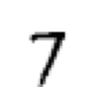

In [71]:
show_image(sevens_tensors[5])

In [72]:
sevens_tensors[0].shape

torch.Size([28, 28])

In [75]:
# now stack the tensors and scaling to 0 and 1 Large numbers (like 255) can cause "gradient explosions" during training,
#making the model unstable. By dividing the entire stack by 255, you scale every single pixel

stacked_sevens = torch.stack(sevens_tensors).float()/255
stacked_threes = torch.stack(threes_tensors).float()/255

In [77]:
stacked_sevens.shape
stacked_sevens.ndim

3

When you stacked your images, you created a rank-3 tensor with a shape like $(6131, 28, 28)$.
Dimension 0: This is the "index" or "page number" in your stack (the 6,131 images).
Dimension 1: The vertical rows of pixels (28 rows).
Dimension 2: The horizontal columns of pixels (28 columns).When you tell PyTorch to take the mean(0), you are telling it: "Look through the entire depth of the stack at every single $(x, y)$ coordinate and average the values you find there."

<Axes: >

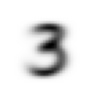

In [78]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

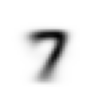

In [79]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)


How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

1. Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm

2. Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

In [82]:
sample_image = stacked_sevens[0]

#calculate its distance
l1_norm = (sample_image - mean7).abs().mean()
l1_norm

tensor(0.1095)

In [83]:
l2_norm = ((sample_image - mean7)**2).mean().sqrt()
l2_norm

tensor(0.2196)

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [84]:
# now using the above loss function using tensor flow built in methods
F.l1_loss(sample_image, mean7)


tensor(0.1095)

In [86]:
F.mse_loss(sample_image,mean7).sqrt()

tensor(0.2196)

## Playing around with numpy and pytorch tensors

In [87]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [88]:
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [89]:
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [90]:
arr.shape

(2, 3)

In [91]:
tns.shape

torch.Size([2, 3])

In [92]:
tns[1]

tensor([4, 5, 6])

In [94]:
tns[1,1:3]

tensor([5, 6])

In [95]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [97]:
tns.type()

'torch.LongTensor'

In [105]:
#will automatically change the type
tns*1.5

tensor([[ 2.2500,  4.5000,  6.7500],
        [ 9.0000, 11.2500, 13.5000]])

In [106]:
tns

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])